In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스(-) 폰트 깨짐 방지
mpl.rc('font', family='NanumBarunGothic')

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.shape, test.shape

((891, 12), (418, 11))

In [6]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Pre-Processing
#### Missing Values

In [7]:
print(set(X_train.columns) - set(test.columns))
print(set(test.columns) - set(X_train.columns))

set()
set()


In [8]:
df = pd.concat([X_train, test], sort=True)
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Age          263
Cabin       1014
Embarked       2
Fare           1
dtype: int64

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Age
        self.low = X['Age'].mean() - X['Age'].std()
        self.high = X['Age'].mean() + X['Age'].std()
        # Embarked
        self.embarked = X['Embarked'].mode()[0]
        # Fare
        self.fare_median = X['Fare'].median()
        return self
    
    def transform(self, X):
        # Age
        size = X['Age'].isnull().sum()
        rnd_age = np.random.randint(self.low, self.high, size)
        X.loc[np.isnan(X['Age']), 'Age'] = rnd_age
        X['Age'] = X['Age'].astype(int)
        # Embarked
        X['Embarked'].fillna(self.embarked, inplace=True)
        # Fare
        X['Fare'].fillna(self.fare_median, inplace=True)
        return X

#### Feature Engineering

In [10]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        _, self.fare_bins = pd.qcut(X['Fare'], 4, retbins=True)
        return self
    
    def transform(self, X):
        ## add features
        X['Age'] = pd.cut(X['Age'], bins=[0, 20, 30, 40, 60, 80], labels=False, include_lowest=True)
        X['HasCabin'] = X['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
        X['Accompanier'] = X['SibSp'] + X['Parch']
        X['IsAlone'] = 0
        X.loc[X['Accompanier']==0, 'IsAlone'] = 1
        X['Fare'] = pd.cut(X['Fare'], bins=self.fare_bins, labels=False, include_lowest=True)
        
        ## mapping
        X.replace({'Sex': {'female': 0, 'male': 1},
                  'Embarked': {'S': 0, 'C': 1, 'Q': 2}}, inplace=True)
        
        ## casting
        X['Sex'].astype(int)
        X['Embarked'].astype(int)
        X['Age'].astype(int)
        X['Fare'].astype(int)
        return X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [11]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(Imputer(), FeatureEngineering())
pipe.fit(X_train, y_train)
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(test)

In [12]:
X_train_transformed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Accompanier,IsAlone
0,3,1,1,1,0,0,0,0,1,0
1,1,0,2,1,0,3,1,1,1,0
2,3,0,1,0,0,1,0,0,0,1
3,1,0,2,1,0,3,0,1,1,0
4,3,1,2,0,0,1,0,0,0,1


In [13]:
train_transformed = pd.concat([X_train_transformed, y_train], axis=1)

#### Correlation

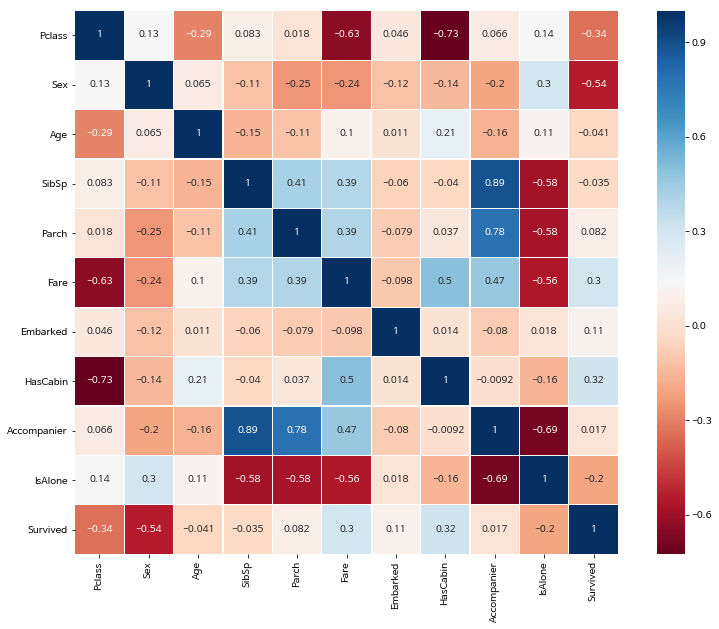

In [14]:
plt.figure(figsize=(14, 10))
cmap = plt.cm.RdBu
sns.heatmap(train_transformed.corr(), cmap=cmap, linewidths=0.1, linecolor='white',
           annot=True, square=True, vmax=1.0)

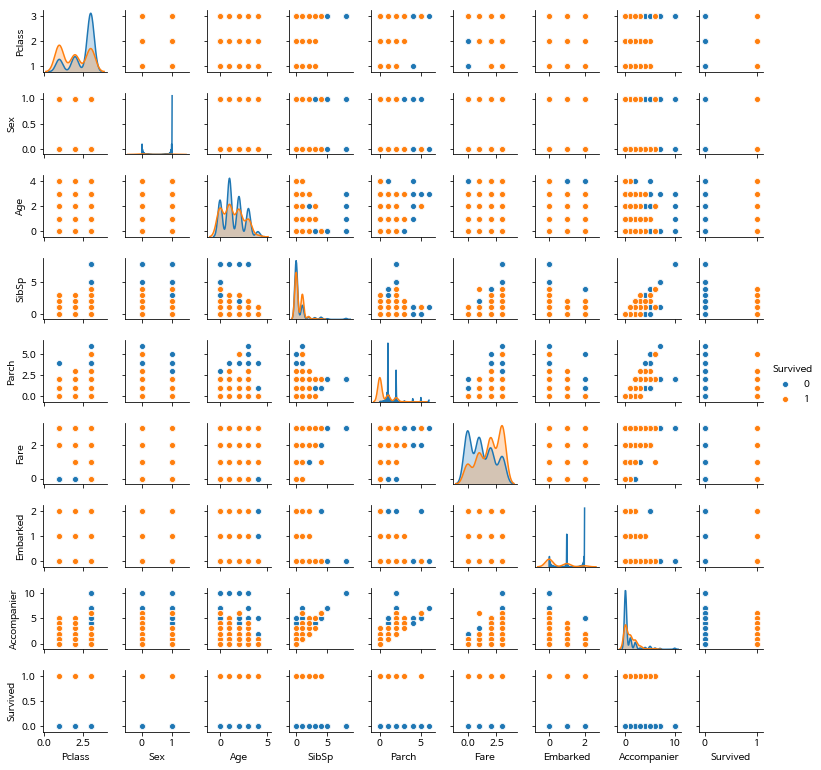

In [15]:
sns.pairplot(train_transformed[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
            'Embarked', 'Accompanier', 'Survived']], hue='Survived', height=1.2)

# Ensembling & Stacking Models

## 1st layer

In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=6, warm_start=True,
                min_samples_leaf=2, max_features='sqrt', verbose=0, n_jobs=-1,
                                 random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=500, max_depth=8, min_samples_leaf=2,
                                verbose=0, n_jobs=-1, random_state=42)
adaboost_clf = AdaBoostClassifier(n_estimators=500, learning_rate=0.75, 
                                     random_state=42)
gradboost_clf = GradientBoostingClassifier(n_estimators=500, max_depth=5, verbose=0,
                                          min_samples_leaf=2, random_state=42)
svc_clf = SVC(kernel='linear', C=0.025, random_state=42)

In [17]:
from sklearn.model_selection import KFold

m_train = X_train_transformed.shape[0]
m_test = X_test_transformed.shape[0]
cv = KFold(5, shuffle=False, random_state=42)

def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((m_train,))
    oof_test = np.empty((5, m_test))
    oof_test_mean = np.zeros((m_test,))
    
    for i, (idx_train, idx_val) in enumerate(cv.split(X_train)):
        X_train_fold = X_train[idx_train]
        y_train_fold = y_train[idx_train]
        X_val_fold = X_train[idx_val]

        clf.fit(X_train_fold, y_train_fold)
        oof_train[idx_val] = clf.predict(X_val_fold)
        oof_test[i, :] = clf.predict(X_test)
    oof_test_mean[:] = oof_test.mean(axis=0)

    return oof_train.reshape(-1, 1), oof_test_mean.reshape(-1, 1)

In [18]:
X_train = X_train_transformed.values
X_test = X_test_transformed.values
y_train = y_train.ravel()

In [19]:
rnd_oof_train, rnd_oof_test = get_oof(rnd_clf, X_train, y_train, X_test)
extra_oof_train, extra_oof_test = get_oof(extra_clf, X_train, y_train, X_test)
adaboost_oof_train, adaboost_oof_test = get_oof(adaboost_clf, X_train, y_train, X_test)
gradboost_oof_train, gradboost_oof_test = get_oof(gradboost_clf, X_train, y_train, X_test)
svc_oof_train, svc_oof_test = get_oof(svc_clf, X_train, y_train, X_test)

#### Feature Importances

In [20]:
rnd_importances = rnd_clf.fit(X_train, y_train).feature_importances_
extra_importances = extra_clf.fit(X_train, y_train).feature_importances_
adaboost_importances =  adaboost_clf.fit(X_train, y_train).feature_importances_
gradboost_importances =  gradboost_clf.fit(X_train, y_train).feature_importances_

In [21]:
importances = pd.DataFrame({'rnd_importances': rnd_importances,
             'extra_importances': extra_importances,
             'adaboost_importances': adaboost_importances,
             'gradboost_importances': gradboost_importances}, 
             index=X_train_transformed.columns.values)
importances

,rnd_importances,extra_importances,adaboost_importances,gradboost_importances
Pclass,0.152511,0.131651,0.034,0.147688
Sex,0.400857,0.516645,0.018,0.456803
Age,0.061945,0.046511,0.036,0.080471
SibSp,0.031586,0.025272,0.252,0.021010
Parch,0.032817,0.020842,0.218,0.033861
Fare,0.110213,0.071851,0.028,0.062039
Embarked,0.033974,0.031185,0.016,0.038063
HasCabin,0.078420,0.090211,0.006,0.060110
Accompanier,0.074660,0.039863,0.380,0.089334
IsAlone,0.023017,0.025969,0.012,0.010620


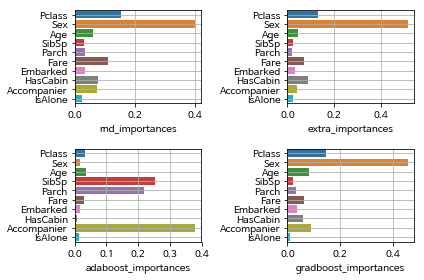

In [22]:
plt.subplot(221)
sns.barplot(importances['rnd_importances'], importances.index.values)
plt.grid()
plt.subplot(222)
sns.barplot(importances['extra_importances'], importances.index.values)
plt.grid()
plt.subplot(223)
sns.barplot(importances['adaboost_importances'], importances.index.values)
plt.grid()
plt.subplot(224)
sns.barplot(importances['gradboost_importances'], importances.index.values)
plt.grid()
plt.tight_layout()

In [23]:
importances['mean'] = importances.mean(axis=1)

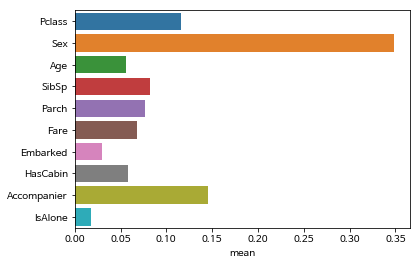

In [24]:
sns.barplot(importances['mean'], importances.index.values)

## 2nd layer

In [25]:
train_pred_from_1st = pd.DataFrame({'RandomForest': rnd_oof_train.ravel(),
                                   'ExtraTrees': extra_oof_train.ravel(),
                                   'AdaBoost': adaboost_oof_train.ravel(),
                                   'GradientBoost': gradboost_oof_train.ravel()})
train_pred_from_1st

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0
9,1.0,1.0,1.0,1.0


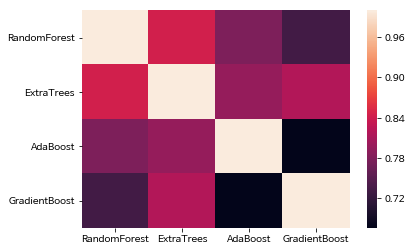

In [26]:
sns.heatmap(train_pred_from_1st.corr())

In [27]:
X_train_for_2nd = np.concatenate((rnd_oof_train, extra_oof_train, adaboost_oof_train,
                                 gradboost_oof_train, svc_oof_train), axis=1)
X_test_for_2nd = np.concatenate((rnd_oof_train, extra_oof_train, adaboost_oof_train,
                                 gradboost_oof_train, svc_oof_train), axis=1)

In [28]:
import xgboost as xgb

xboost = xgb.XGBClassifier(n_estimators=2000, max_depth=4, min_child_weight=2, 
                       gamma=0.9, subsample=0.8, colsample_bytree=0.8, 
                       objective='binary:logistic', nthread=-1, scale_pos_weight=1)
xboost.fit(X_train, y_train)
xboost_pred = xboost.predict(X_test)

#### submission 

In [29]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 
                          'Survived': xboost_pred})
print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [30]:
submission.to_csv('./submission.csv', index=False)